# Machine learning project: predicting will there be snow on christmas 2024

In [1]:
#import all relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.model_selection import train_test_split

In [2]:
# Reading the data from Weather-dataset

data = pd.read_csv('WeatherDataset.csv')
data.drop(columns=['Observation station', 'Time [Local time]'], inplace=True)


In [3]:
#Create new binary_snow column 
max_snow_depth = data['Snow depth [cm]'].max()

binary_labels = [0, 1]
binary_cut_bins = [-1, 0, max_snow_depth]

binary_snow = pd.cut(data['Snow depth [cm]'], bins=binary_cut_bins, labels=binary_labels, include_lowest=True)
data.insert(7, 'binary_snow', binary_snow)

#convert -1 values to 0's
data['Precipitation amount [mm]'] = [0 if i == '-1' else i for i in data['Precipitation amount [mm]']]
data['Snow depth [cm]'] = [0 if i == '-1' else i for i in data['Snow depth [cm]']]

data.head()
print(len(data[data['Snow depth [cm]'] == '-1']))
print(len(data[data['Precipitation amount [mm]'] == '-1']))

0
0


## Preliminary analysis charts

In [4]:
#Plotting the average snow and precipitation from various years
data_december = data[data["Month"] == 12].copy()
for col in data_december.columns:
    data_december[col] = pd.to_numeric(data_december[col], errors='coerce')
    
    
snow_depth_avg = data_december.groupby('Year')['Snow depth [cm]'].mean()

precipitation_avg = data_december.groupby('Year')['Precipitation amount [mm]'].mean()


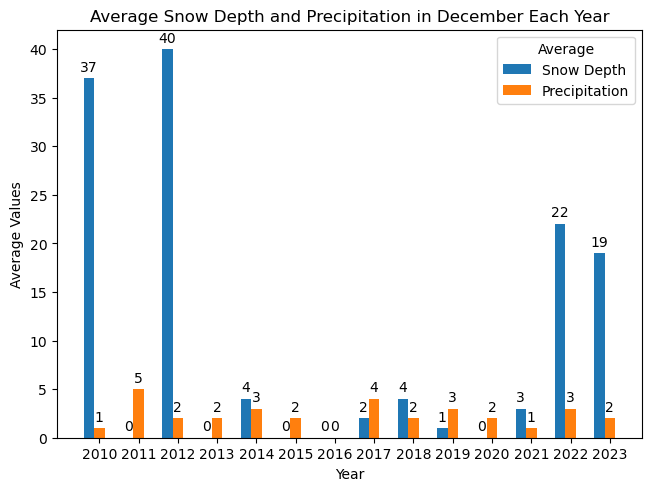

In [5]:
# Show the average snow and precipitation through the years
indeces = snow_depth_avg.index
values = (snow_depth_avg.values, precipitation_avg.values)
labels = ["Snow Depth", "Precipitation"]
colors = ["tab:red", "tab:blue"]

label_loc = np.arange(14)*3
width = 0.8
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for i in range(2):
    offset = width * multiplier
    rectangles = ax.bar(label_loc + offset, np.round(values[i], decimals=0), label=labels[i])
    ax.bar_label(rectangles, padding=3)
    multiplier += 1
    

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Values')
ax.set_xticks(label_loc + width, indeces)
plt.title('Average Snow Depth and Precipitation in December Each Year')

# Add legend
plt.legend(title='Average')

# Show the plot
plt.show()

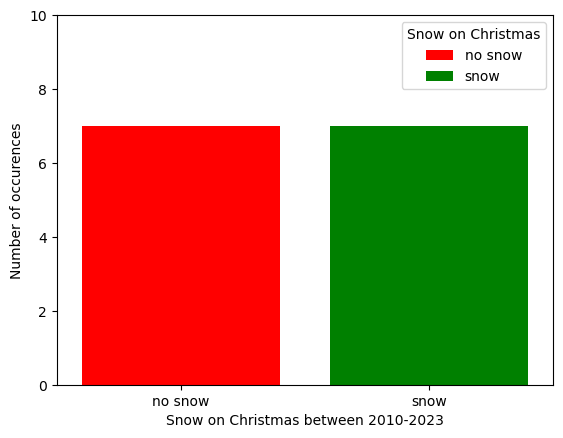

In [6]:
#Plotting which years has had snow on 24th december
data_christmas = data_december[data_december['Day'] == 24]

grouped_data = data_christmas.groupby('Year')['binary_snow'].mean()


fig, ax_ch = plt.subplots()

counts = grouped_data.value_counts()
value = ('no snow', 'snow')
labels = ('no snow', 'snow')
colors = ('red', 'green')

ax_ch.bar(value, counts, label=labels, color=colors)

ax_ch.set_ylabel('Number of occurences')
ax_ch.set_xlabel('Snow on Christmas between 2010-2023')
ax_ch.set_ylim(0,10)
ax_ch.set_xlim(-0.5,1.5)

ax_ch.legend(title='Snow on Christmas')
plt.show()

### Dataset Preprocessing

In [7]:
#creating Day of the year column and replacing Year, month and day columns
data['date_time'] = pd.to_datetime(data.iloc[:,0:3]) 
day_of_year = data['date_time'].dt.dayofyear

data.insert(3, 'Day of the year', day_of_year)
data.drop(columns=['Month', 'Day', 'date_time'], inplace=True)
#Drop all rows containing NaN values
data.dropna(inplace=True)
print(data.isna().sum().sum())
data.head()

0


,Year,Day of the year,Precipitation amount [mm],Snow depth [cm],Average temperature [°C],Minimum temperature [°C],binary_snow
0,2010,1,0.1,41,-14.2,-16.9,1
1,2010,2,0.1,40,-18.9,-20.8,1
2,2010,3,1.1,38,-15.8,-25.6,1
3,2010,4,2.9,40,-6.8,-9,1
4,2010,5,0.6,44,-11.4,-19.1,1


In [8]:
#Setting target variable 'y' and features
y = data['binary_snow']
X = data.drop(columns=['binary_snow'])
for col in X.columns:
    X[col] = pd.to_numeric(X[col].replace('-', 0), errors='coerce')


In [9]:
#Normalize the dataset
scl = StandardScaler()
X_scaled = X
#Change Day of the year column into sin & cos representation for cyclical recognision
X_scaled['Day_sin'] = np.sin(2 * np.pi * day_of_year / 365)
X_scaled['Day_cos'] = np.cos(2 * np.pi * day_of_year / 365)
X_scaled[['Precipitation amount [mm]', 'Snow depth [cm]', 'Average temperature [°C]', 'Minimum temperature [°C]']] = scl.fit_transform(X[['Precipitation amount [mm]', 'Snow depth [cm]', 'Average temperature [°C]', 'Minimum temperature [°C]']])

X_scaled.drop('Day of the year', axis=1, inplace=True)
X_scaled

,Year,Precipitation amount [mm],Snow depth [cm],Average temperature [°C],Minimum temperature [°C],Day_sin,Day_cos
0,2010,-0.350631,1.886119,-2.241887,-2.213490,1.721336e-02,0.999852
1,2010,-0.350631,1.828544,-2.753207,-2.656195,3.442161e-02,0.999407
2,2010,-0.118618,1.713393,-2.415953,-3.201063,5.161967e-02,0.998667
3,2010,0.299006,1.828544,-1.436830,-1.316728,6.880243e-02,0.997630
4,2010,-0.234624,2.058844,-1.937270,-2.463221,8.596480e-02,0.996298
...,...,...,...,...,...,...,...
5108,2023,-0.327429,1.137642,-1.219246,-1.214566,-6.880243e-02,0.997630
5109,2023,-0.141819,1.137642,-0.936389,-0.942132,-5.161967e-02,0.998667
5110,2023,1.505472,1.252792,-0.794960,-0.510778,-3.442161e-02,0.999407
5111,2023,-0.049014,1.598243,-1.153972,-1.010240,-1.721336e-02,0.999852


In [10]:
#Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
#Split temporary into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5) 
X_train

,Year,Precipitation amount [mm],Snow depth [cm],Average temperature [°C],Minimum temperature [°C],Day_sin,Day_cos
4039,2021,0.066993,2.404295,-0.577377,-0.783212,0.369725,0.929141
576,2011,-0.605845,-0.474463,1.467904,1.600585,-0.486273,-0.873807
4013,2020,-0.141819,-0.474463,-0.707926,-0.805915,-0.051620,0.998667
4538,2022,-0.605845,-0.474463,0.869551,0.851391,0.440519,-0.897743
1180,2013,-0.605845,3.498223,-0.979905,-1.032943,0.994218,0.107381
...,...,...,...,...,...,...,...
4429,2022,1.992700,1.886119,-0.522981,-0.170236,0.723644,0.690173
466,2011,-0.605845,0.331590,-0.229244,-0.340507,0.982927,-0.183998
3092,2018,-0.605845,-0.474463,1.119771,1.101123,0.196673,-0.980469
3772,2020,-0.605845,-0.474463,-0.414189,-0.578886,0.871706,-0.490029


## Stage 2

In [11]:
#Training the model and validating it
lg = LogisticRegression(max_iter=1000)
lg.fit(X_train, y_train)

y_pred = lg.predict(X_val)
y_pred_test = lg.predict(X_test)

accuracy_val = accuracy_score(y_val, y_pred)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"Accuracy: {accuracy_val*100:.2f}%")
print(f"Accuracy: {accuracy_test*100:.2f}%")


conf_mat = confusion_matrix(y_test, y_pred_test)
conf_matval = confusion_matrix(y_val, y_pred)

Accuracy: 97.52%
Accuracy: 97.26%


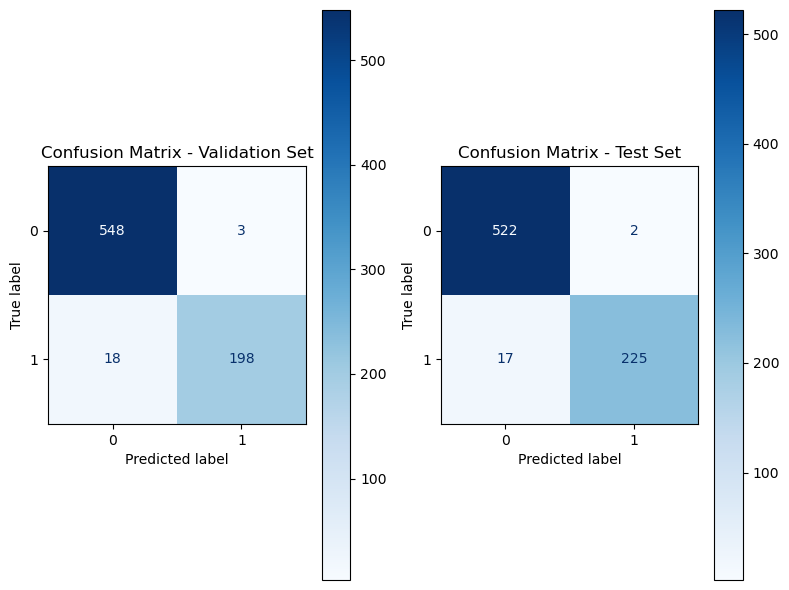

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
ConfusionMatrixDisplay(conf_mat).plot(ax=ax1, cmap='Blues')
ax1.set_title('Confusion Matrix - Validation Set')

# Plotting two confusion matrices for test sets side by side
ConfusionMatrixDisplay(conf_matval).plot(ax=ax2, cmap='Blues')
ax2.set_title('Confusion Matrix - Test Set')

# Adjusting layout
plt.tight_layout()
plt.show()

In [13]:
#Using MLPregressor to get an alternative 'opinion' for the prediction
mlp = MLPClassifier(hidden_layer_sizes=(20,), activation='relu', max_iter=1000, random_state=42)

# Training the model
mlp.fit(X_train, y_train)

#Predicting for validation and test sets
y_predmlp = mlp.predict(X_val)
y_predmlp_test = mlp.predict(X_test)

#Checking accuracy
accuracy_mlp = accuracy_score(y_test, y_predmlp_test)
accuracy_mlp_val = accuracy_score(y_val, y_predmlp)
print(f"Accuracy: {accuracy_mlp*100:.2f}%")
print(f"Accuracy: {accuracy_mlp_val*100:.2f}%")


Accuracy: 96.22%
Accuracy: 94.52%


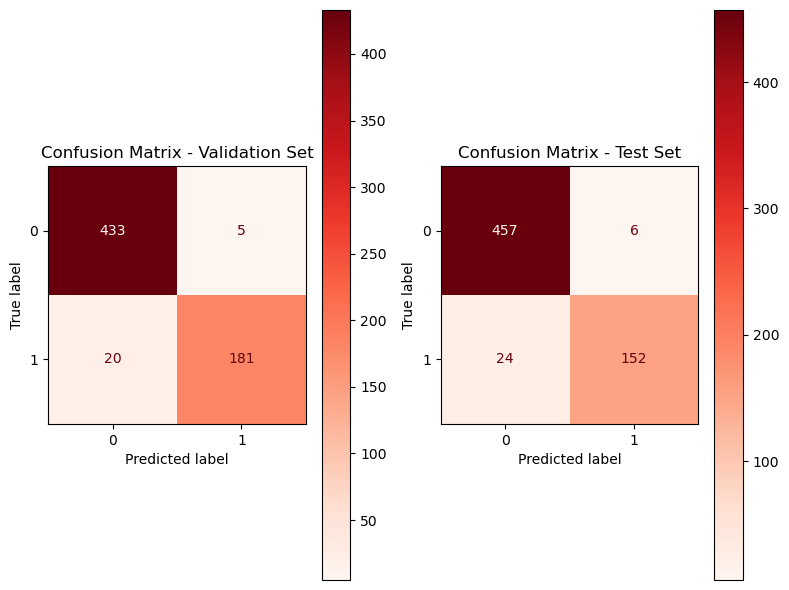

In [14]:
conf_mat_val = confusion_matrix(y_val, y_predmlp)
conf_mat_mlp = confusion_matrix(y_test, y_predmlp_test)

# Plot confusion matrices for test and validation set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
ConfusionMatrixDisplay(conf_mat_val).plot(ax=ax1, cmap='Reds')
ax1.set_title('Confusion Matrix - Validation Set')

ConfusionMatrixDisplay(conf_mat_mlp).plot(ax=ax2, cmap='Reds')
ax2.set_title('Confusion Matrix - Test Set')

# Adjust layout
plt.tight_layout()
plt.show()

In [20]:
#Training LinearRegression model to predict the weather conditions for Christmas 2024
#Setting up new y's for each prediction
y_precip = data['Precipitation amount [mm]']
y_snow = data['Snow depth [cm]']
y_avg_temp = data['Average temperature [°C]']
y_min_temp = data['Minimum temperature [°C]']
#Y_min_temp NaN values replaced with 0's
y_min_temp.fillna(0, inplace=True)
y_min_temp = y_min_temp.replace('-', '0') 
print(y_min_temp)

#Using values from previous Christmas evenings to predict the mean of this years weather data 
day_24_sin = np.sin(2 * np.pi *  358 / 365)
day_24_cos = np.cos(2 * np.pi * 358 / 365)

rows_24_12 = X_scaled[(X_scaled['Day_sin'] == day_24_sin) & (X_scaled['Day_cos'] == day_24_cos)] 



0       -16.9
1       -20.8
2       -25.6
3          -9
4       -19.1
        ...  
5108     -8.1
5109     -5.7
5110     -1.9
5111     -6.3
5112    -16.9
Name: Minimum temperature [°C], Length: 5109, dtype: object


In [21]:
#Training and fitting the model for precipitation and making prediction
lm = LinearRegression()
lm.fit(X_scaled, y_precip)

y_pred_precip = lm.predict(rows_24_12)
avg_precip = np.mean(y_pred_precip)

lm.fit(X_scaled, y_snow)
y_pred_snow = lm.predict(rows_24_12)
avg_snow = np.mean(y_pred_snow)

lm.fit(X_scaled, y_avg_temp)
y_pred_avg_temp = lm.predict(rows_24_12)
avg_avg_temp = np.mean(y_pred_avg_temp)

lm.fit(X_scaled, y_min_temp)
y_pred_min = lm.predict(rows_24_12)
avg_min = np.mean(y_pred_min)

In [22]:
#Creating dataset for Logisticregression and MLPregressor to make a prediction
prediction_data = pd.DataFrame({
    'Year': [2024],
    'Precipitation amount [mm]': [avg_precip],
    'Snow depth [cm]': [avg_snow],
    'Average temperature [°C]': [avg_avg_temp],
    'Minimum temperature [°C]': [avg_min], 
    'Day_sin': [day_24_sin], 
    'Day_cos': [day_24_cos],
})

In [23]:
#Making prediction
snow_prediction_lg = lg.predict(prediction_data)
snow_prediction_mlp = mlp.predict(prediction_data)

print(f"Is there snow on christmas 2024, according to Logistic model: {'Yes' if snow_prediction_lg[0] == 1 else 'No'}")
print(f"Is there snow on christmas 2024, according to MLP model: {'Yes' if snow_prediction_mlp[0] == 1 else 'No'}")

Is there snow on christmas 2024, according to Logistic model: Yes
Is there snow on christmas 2024, according to MLP model: Yes
